## Online Music Store Analysis

In this project, we will examine sales from a fictional online music store [Chinook](https://github.com/lerocha/chinook-database). We will explore a database that contains tables of information about the employees, customers, and music involved in Chinook's business. We will examine trends and look for opportunities for Chinook to improve its business.

We will use a combination of SQL queries, graphs, and a map to examine the data. Here is the schema diagram of the Chinook database that will help us code our queries:



In [38]:
# Import modules
import pandas as pd
import sqlite3
import sqlalchemy as sal
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import folium
from folium import plugins
%matplotlib inline

# Load chinook database

db_name = "chinook.db"
engine = sal.create_engine("sqlite:///%s" % db_name)


In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [3]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table", "view")

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


In [4]:
# Create list of tables in database
table_list = list(pd.read_sql_query("SELECT name FROM sqlite_master WHERE type = 'table'", engine)['name'])
print(f'\033[1mHere are the tables we can use in our analysis:\033[0m \n{table_list}')


Here are the tables we can use in our analysis: 
['album', 'artist', 'customer', 'employee', 'genre', 'invoice', 'invoice_line', 'media_type', 'playlist', 'playlist_track', 'track']


In [5]:
# Create pandas dataframe for each table to have as a resource
for table in table_list:
    query = f'SELECT * FROM {table}'
    globals()[table] = pd.read_sql_query(query, engine)

## Sales Changes Over Time

We will examine how sales have changed over time to see how Chinook's sales numbers have been trending. We will look at sales by month.

In [6]:
# Query sales figures from invoice table and group by year/month
query = '''

SELECT STRFTIME("%Y-%m", invoice_date) AS month, ROUND(SUM(total),2) total_sales

FROM invoice
GROUP BY 1

'''

# Read in above query results into Pandas dataframe
monthly_sales = pd.read_sql_query(query, engine)


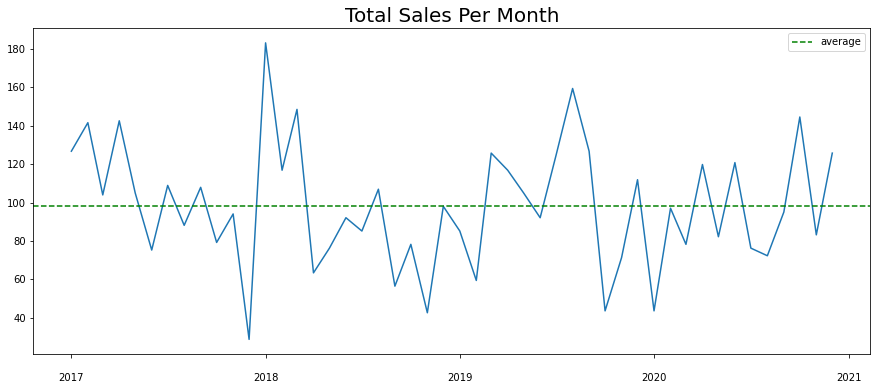

In [41]:
# Convert month column to datetime format
monthly_sales['month'] = pd.to_datetime(monthly_sales['month'])

# Create plot of sales per month
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(monthly_sales['month'], monthly_sales['total_sales'])

# Make x-axis scale by year
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter("\n%Y"))

# Create average sale line
plt.axhline(y = monthly_sales['total_sales'].mean(), color = 'g', linestyle = '--', label='average')
plt.legend()
plt.title('Total Sales Per Month',size=20)
plt.show()

The monthly sales at the beginning (January 2017) and end (December 2021) of our dataset are about the same: about \\$125 per month. At the end of 2017 there was a large drop to about \\$20 per month and then a sharp rise to over \\$180. There are other spikes that occur over time.

We will now look at sales for differnet months of the year to see if sales have any seasonal trends.

In [8]:
# Query sales figures by calendar month from invoice table

query = '''

SELECT STRFTIME("%m", invoice_date) AS month, ROUND(SUM(total)/4,2) total_sales

FROM invoice
GROUP BY 1

'''

# Read in above query results into Pandas dataframe
monthly_trends = pd.read_sql_query(query, engine)


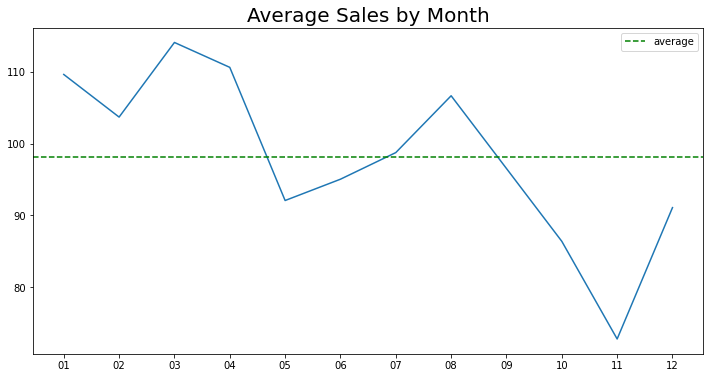

In [42]:
# Create plot of sales by calendar month
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(monthly_trends['month'], monthly_trends['total_sales'])

# Create average sale line
plt.axhline(y = monthly_trends['total_sales'].mean(), color = 'g', linestyle = '--', label='average')
plt.legend()
plt.title('Average Sales by Month',size=20)
plt.show()

Sales tend to be highest in January, February and March. There is a small peak from mid-July to mid-August. Sales are lowest in October and November. Further research might be helpful to determine what causes the mid-July peak and what can be done to extend this peak into fall months.

## Analyzing Genres

One question we may have is what genres are most popular. This could help determine what type of music Chinook should focus on.

In [10]:
%%sql

SELECT g.name genre, COUNT(il.invoice_line_id) tracks_sold, ROUND(CAST(100*COUNT(il.invoice_line_id) AS FLOAT)/(SELECT COUNT(track_id)
FROM invoice i
INNER JOIN invoice_line il on il.invoice_id = i.invoice_id),1)

percentage
    FROM invoice i
    LEFT JOIN invoice_line il ON il.invoice_id = i.invoice_id
    LEFT JOIN track t ON t.track_id = il.track_id
    LEFT JOIN genre g ON t.genre_id = g.genre_id
        GROUP BY 1
        ORDER BY 2 DESC

 * sqlite:///chinook.db
Done.


genre,tracks_sold,percentage
Rock,2635,55.4
Metal,619,13.0
Alternative & Punk,492,10.3
Latin,167,3.5
R&B/Soul,159,3.3
Blues,124,2.6
Jazz,121,2.5
Alternative,117,2.5
Easy Listening,74,1.6
Pop,63,1.3


Rock, Metal, and Alternative & Punk make up almost 80% of global sales. We will now examine how sales in these genres have changed over time.

In [11]:
%%sql

SELECT g.name genre, STRFTIME("%Y-%m", i.invoice_date) AS month , COUNT(i.invoice_id) tracks_sold
FROM track t
INNER JOIN album al on al.album_id = t.album_id
INNER JOIN artist ar on ar.artist_id = al.artist_id
INNER JOIN invoice_line il on il.track_id = t.track_id
INNER JOIN invoice i on i.invoice_id = il.invoice_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1,2
LIMIT 5

 * sqlite:///chinook.db
Done.


genre,month,tracks_sold
Alternative,2017-01,3
Alternative,2017-02,1
Alternative,2017-03,5
Alternative,2017-04,5
Alternative,2017-05,3


In [12]:
# Extract number of sales by genre by month into pandas dataframe
query = '''

SELECT g.name genre, STRFTIME("%Y-%m", i.invoice_date) AS month , COUNT(i.invoice_id) tracks_sold
FROM track t
INNER JOIN album al on al.album_id = t.album_id
INNER JOIN artist ar on ar.artist_id = al.artist_id
INNER JOIN invoice_line il on il.track_id = t.track_id
INNER JOIN invoice i on i.invoice_id = il.invoice_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1,2

'''

genre_sale_trends = pd.read_sql_query(query, engine)
genre_sale_trends['month'] = pd.to_datetime(genre_sale_trends['month'])


<IPython.core.display.Javascript object>


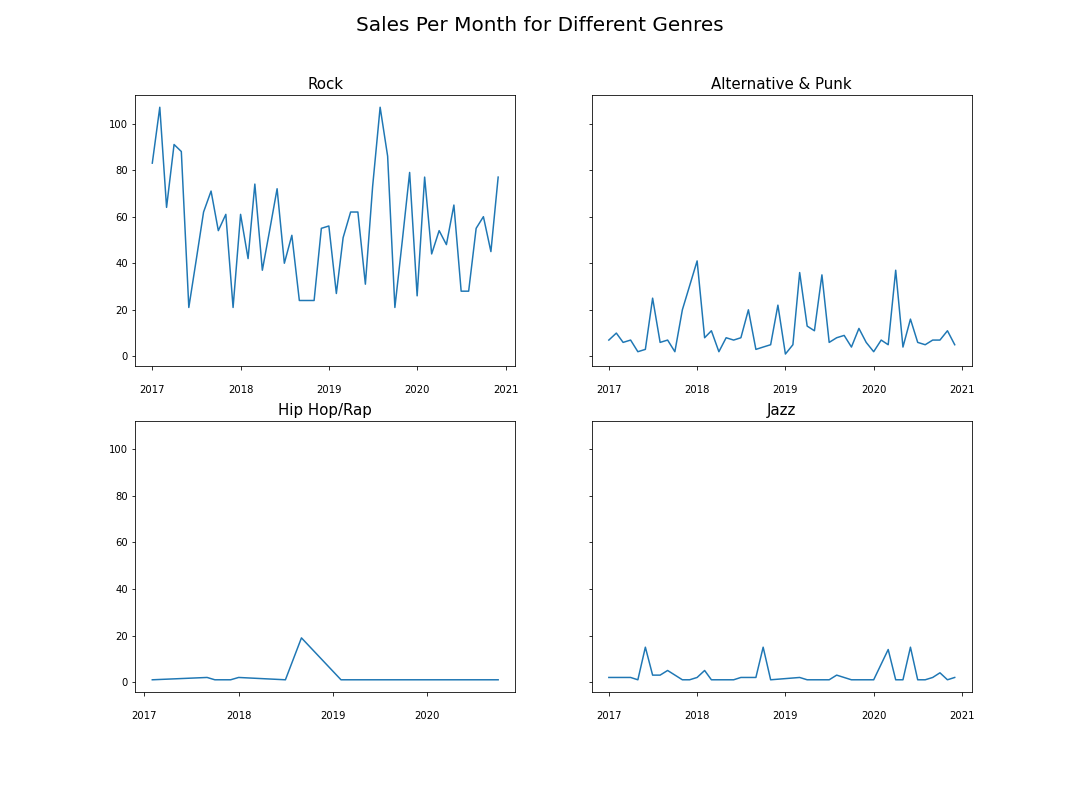

In [36]:
# Create 4 subplots to show sales per month for Rock, Alternative & Punk, Hip Hop/Rap, and Jazz
fig, ax = plt.subplots(2,2,sharey = True,figsize=(15,11))
fig.suptitle('Sales Per Month for Different Genres',size=20)


df = genre_sale_trends[genre_sale_trends['genre']=='Rock']
ax[0,0].plot(df['month'], df['tracks_sold'])
ax[0,0].xaxis.set_major_locator(dates.YearLocator())
ax[0,0].xaxis.set_major_formatter(dates.DateFormatter("\n%Y"))
ax[0,0].set_title('Rock', size = 15)

df = genre_sale_trends[genre_sale_trends['genre']=='Alternative & Punk']
ax[0,1].plot(df['month'], df['tracks_sold'])
ax[0,1].xaxis.set_major_locator(dates.YearLocator())
ax[0,1].xaxis.set_major_formatter(dates.DateFormatter("\n%Y"))
ax[0,1].set_title('Alternative & Punk', size = 15)

df = genre_sale_trends[genre_sale_trends['genre']=='Hip Hop/Rap']
ax[1,0].plot(df['month'], df['tracks_sold'])
ax[1,0].xaxis.set_major_locator(dates.YearLocator())
ax[1,0].xaxis.set_major_formatter(dates.DateFormatter("\n%Y"))
ax[1,0].set_title('Hip Hop/Rap', size = 15)

df = genre_sale_trends[genre_sale_trends['genre']=='Jazz']
ax[1,1].plot(df['month'], df['tracks_sold'])
ax[1,1].xaxis.set_major_locator(dates.YearLocator())
ax[1,1].xaxis.set_major_formatter(dates.DateFormatter("\n%Y"))
ax[1,1].set_title('Jazz', size = 15)
plt.show()

There are not any clear trends in how the sales of tracks from these genres changed over time. There was a relatively large increase in Hip Hop sales in the third quarter of 2018, but sales returned to their previous, low rate soon after. Sales of Rock tracks also fluctuate often with the largest spike happening in the middle of 2019. It could be worth doing further research to better understand the reason behind these fluctuations. Perhaps there is something on social media or popular culture that creates these popularity spikes.

## Analzying Sales Support Agents

At Chinook, each customer is connected to a Sales Support Agent. We will examine the purchases of customers linked to different employees to see how the Sales Suppoort Agents are performing.

In [14]:
%%sql
SELECT * FROM employee
WHERE title = 'Sales Support Agent'


 * sqlite:///chinook.db
Done.


employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com


In [15]:
%%sql
WITH sales_support_agent AS
    (
        SELECT *
        FROM employee
        WHERE title = 'Sales Support Agent'
    )
    
SELECT ssa.first_name || " " || ssa.last_name employee, STRFTIME("%Y-%m-%d", ssa.hire_date) AS hire_date , 
COUNT(c.customer_id) customers, ROUND(SUM(i.total),0) total_sales, ROUND(SUM(i.total)/COUNT(c.customer_id),2) sales_per_customer
    FROM sales_support_agent ssa
    INNER JOIN customer c ON c.support_rep_id = ssa.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY 1

 * sqlite:///chinook.db
Done.


employee,hire_date,customers,total_sales,sales_per_customer
Jane Peacock,2017-04-01,212,1732.0,8.17
Margaret Park,2017-05-03,214,1584.0,7.4
Steve Johnson,2017-10-17,188,1394.0,7.41


Jane has the most sales, but she was hired first. Steve has the lowest sales, but he was hired most recently. It seems that the longer an employee has worked there, the more total sales they have.

## Band Popularity

Below we will find the artists that appear in the most playlists. Understanding what music customers are listening to could help predict what music they would be interested in purchasing. We will identify the most popular band by counting how many playlists it was included in.

In [16]:
%%sql
SELECT ar.name band_name, COUNT(DISTINCT pl.playlist_id) playlist_counts
    FROM playlist pl
    LEFT JOIN playlist_track pt ON pl.playlist_id = pt.playlist_id
    LEFT JOIN track t ON t.track_id = pt.track_id
    LEFT JOIN album al ON al.album_id = t.album_id
    LEFT JOIN artist ar ON ar.artist_id = al.artist_id
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 5


 * sqlite:///chinook.db
Done.


band_name,playlist_counts
Eugene Ormandy,7
The King's Singers,6
English Concert & Trevor Pinnock,6
Berliner Philharmoniker & Herbert Von Karajan,6
Academy of St. Martin in the Fields & Sir Neville Marriner,6


## Most popular band by country

We will now use track purchases to determine the most popular band in each country.

In [18]:
%%sql

WITH country_band_sold AS (SELECT i.billing_country country, ar.name band, count(il.invoice_id) tracks_sold
FROM track t
INNER JOIN album al on al.album_id = t.album_id
INNER JOIN artist ar on ar.artist_id = al.artist_id
INNER JOIN invoice_line il on il.track_id = t.track_id
INNER JOIN invoice i on i.invoice_id = il.invoice_id
GROUP BY 1,2)

SELECT cbs.country, cbs.band, cbs.tracks_sold 

FROM country_band_sold cbs

WHERE cbs.tracks_sold = (SELECT max(tracks_sold) 
        FROM country_band_sold
        WHERE cbs.country=country
        GROUP BY country
        )


 * sqlite:///chinook.db
Done.


country,band,tracks_sold
Argentina,Green Day,14
Australia,The Clash,18
Austria,Miles Davis,15
Belgium,Godsmack,12
Brazil,Metallica,36
Canada,Queen,36
Chile,Red Hot Chili Peppers,15
Czech Republic,Kiss,21
Denmark,Jamiroquai,4
Finland,The Police,14


Most of the bands listed in the country favorites table appear to be Rock bands. We will now examine the favorite genre of each country to see if they really do favor Rock.

In [19]:
%%sql

WITH country_genre_sold AS (SELECT i.billing_country country, g.name genre, count(il.invoice_id) tracks_sold
FROM track t
INNER JOIN album al on al.album_id = t.album_id
INNER JOIN artist ar on ar.artist_id = al.artist_id
INNER JOIN invoice_line il on il.track_id = t.track_id
INNER JOIN invoice i on i.invoice_id = il.invoice_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1,2)

SELECT cgs.country, cgs.genre, cgs.tracks_sold 

FROM country_genre_sold cgs

WHERE cgs.tracks_sold = (SELECT max(tracks_sold) 
        FROM country_genre_sold
        WHERE cgs.country=country
        GROUP BY country
        )

 * sqlite:///chinook.db
Done.


country,genre,tracks_sold
Argentina,Alternative & Punk,17
Australia,Rock,34
Austria,Rock,40
Belgium,Rock,26
Brazil,Rock,205
Canada,Rock,333
Chile,Rock,61
Czech Republic,Rock,143
Denmark,Rock,24
Finland,Rock,46


Argentina was the only country with a favorite genre that was not Rock. Chinook appears to be very popular with fans of Rock music across the world.


## Sales by Country

We will now examine sales by country to see how customers from different countries are engaging with Chinook.

In [20]:
%%sql

WITH customers_invoices AS (SELECT * 
                            FROM customer c
                            INNER JOIN invoice i ON c.customer_id = i.customer_id)

SELECT 
    ci.country,
    ROUND(SUM(ci.total),2) sales_total,
    ROUND(100*SUM(ci.total)/(SELECT SUM(c_i.total) FROM customers_invoices c_i),2) sale_percentage,
    COUNT(ci.customer_id) number_of_customers, 
    ROUND(SUM(ci.total)/COUNT(ci.customer_id),2) avg_sale_per_customer
FROM customers_invoices ci
GROUP BY 1
ORDER BY 3 DESC


 * sqlite:///chinook.db
Done.


country,sales_total,sale_percentage,number_of_customers,avg_sale_per_customer
USA,1040.49,22.09,131,7.94
Canada,535.59,11.37,76,7.05
Brazil,427.68,9.08,61,7.01
France,389.07,8.26,50,7.78
Germany,334.62,7.11,41,8.16
Czech Republic,273.24,5.8,30,9.11
United Kingdom,245.52,5.21,28,8.77
Portugal,185.13,3.93,29,6.38
India,183.15,3.89,21,8.72
Ireland,114.84,2.44,13,8.83


In [21]:
# Query sales by country

query = '''
WITH customers_invoices AS (SELECT * 
                            FROM customer c
                            INNER JOIN invoice i ON c.customer_id = i.customer_id)

SELECT 
    ci.country,
    ROUND(SUM(ci.total),2) sales_total,
    ROUND(100*SUM(ci.total)/(SELECT SUM(c_i.total) FROM customers_invoices c_i),2) sale_percentage,
    COUNT(ci.customer_id) number_of_customers, 
    ROUND(SUM(ci.total)/COUNT(ci.customer_id),2) avg_sale_per_customer
FROM customers_invoices ci
GROUP BY 1
ORDER BY 3 DESC

'''
# Turn query into pandas dataframe
country_sales = pd.read_sql_query(query, engine)

# Get list of top spending countries for later analysis
top_spending_countries = list(country_sales[country_sales['sale_percentage']>5]['country'])

# Label all countries with less than 5% of global sales at 'Other'
low_sales_countries = country_sales[country_sales['sale_percentage']<5].index
top_country_sales = country_sales.copy()
top_country_sales.loc[low_sales_countries,'country'] = 'Other'
top_country_sales = top_country_sales.groupby('country').sum()

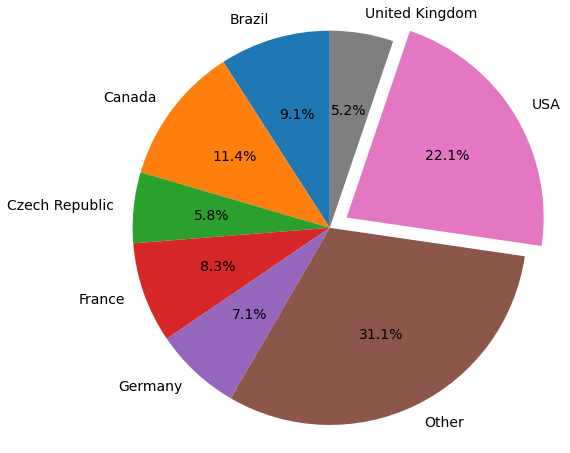

In [39]:
# Create pie chart with USA slice exploded

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(top_country_sales['sale_percentage'], labels=top_country_sales.index, autopct='%1.1f%%',
       startangle=90, explode = (0, 0, 0, 0,0,0,.1,0), textprops={'fontsize': 14})
ax.axis('equal')
plt.show()


Customers in the USA spent the most money at Chinook by far at just over 22%. Just seven countries make up almsot 70% of Chinook's sales.

In [23]:
# Rename USA to match name in map file
def usa_fix(item):
    if item == 'USA':
        return 'United States of America'
    else:
        return item
country_sales['country'] = country_sales['country'].apply(usa_fix)

In [24]:
# Create function to create country heatmap
def country_map(country_data, col, legend, color, title):   
    # Create base map 
    temp_map = folium.Map(location=[0,0], zoom_start=2,
                          tiles='CartoDB positron')
    
    # Identify location of geojson file
    geo_path = 'full_world_map.geo.json'
    
    # Add country borders to map and fill color representing column data value
    cp = folium.Choropleth(
        geo_data=geo_path,
        data=country_data,
        columns=['country', col],
        key_on="feature.properties.name",
        fill_color=color,
        fill_opacity=0.7,
        line_opacity=0.5,
        legend_name= legend,
        #bins=bins,
        reset=True,
    ).add_to(temp_map)

    #Add title
    title_html = '''
             <h3 align="center" style="font-size:20px"><b>{}</b></h3>
             '''.format(title)
    temp_map.get_root().html.add_child(folium.Element(title_html))
    
    country_data_indexed = country_data.set_index('country')
    cp.geojson.data
    
    return temp_map

In [25]:
# Use map function to create heat map of total sales by country
sales_map = country_map(country_sales, 'sales_total', 'Total Sales', 'YlGnBu', 'Spending by Country')
sales_map

The map above provides a visual for where sales are happening. There are many parts of the world that the music store is not reaching. Since sales are high in North America and parts of South America, perhaps it would be possible to expand into Central America and parts of South America. 

We will now look at how sales have changed over time in some of the largest markets of the Chinook store.

In [26]:
# Query sales by month for each country
query = '''

SELECT i.billing_country country, STRFTIME("%Y-%m", i.invoice_date) AS month , COUNT(i.invoice_id) tracks_sold
FROM track t
INNER JOIN album al on al.album_id = t.album_id
INNER JOIN artist ar on ar.artist_id = al.artist_id
INNER JOIN invoice_line il on il.track_id = t.track_id
INNER JOIN invoice i on i.invoice_id = il.invoice_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1,2

'''



# Import monthly country sales to dataframe
country_sale_trends = pd.read_sql_query(query, engine)

country_sale_trends.head()

,country,month,tracks_sold
0,Argentina,2018-04,9
1,Argentina,2018-12,7
2,Argentina,2019-06,23
3,Argentina,2020-07,1
4,Australia,2017-02,2


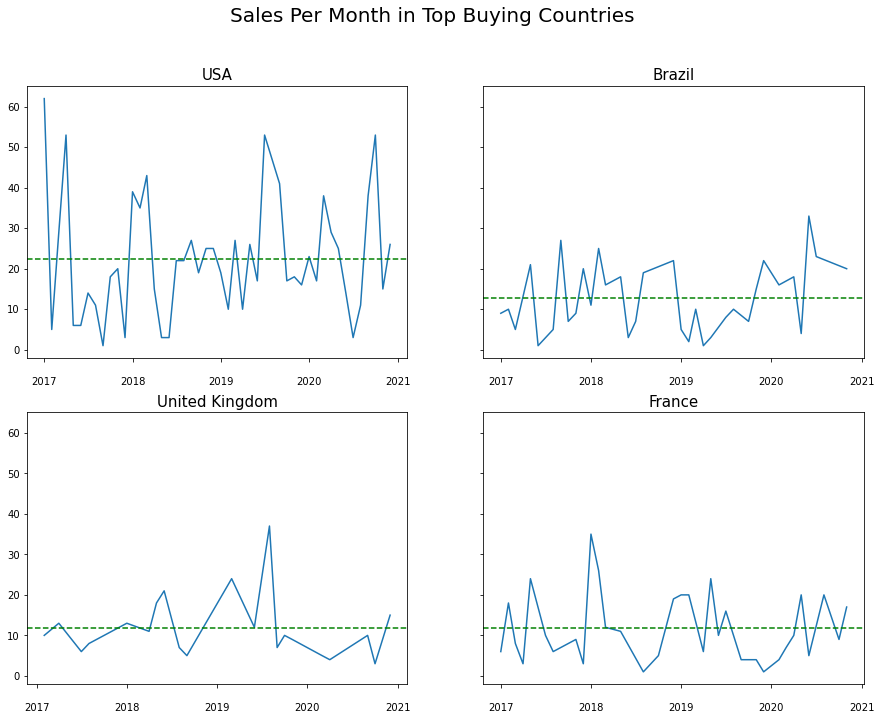

In [27]:
# Convert month data to datetime
country_sale_trends['month'] = pd.to_datetime(country_sale_trends['month'])

# Create 4 subplots for sales per month for USA, Brazil, UK, and France
fig, ax = plt.subplots(2,2,sharey = True,figsize=(15,11))
fig.suptitle('Sales Per Month in Top Buying Countries',size=20)


df = country_sale_trends[country_sale_trends['country']=='USA']
ax[0,0].plot(df['month'], df['tracks_sold'])
ax[0,0].xaxis.set_major_locator(dates.YearLocator())
ax[0,0].xaxis.set_major_formatter(dates.DateFormatter("\n%Y"))
ax[0,0].set_title('USA', size = 15)
ax[0,0].axhline(y = df['tracks_sold'].mean(), color = 'g', linestyle = '--')



df = country_sale_trends[country_sale_trends['country']=='Brazil']
ax[0,1].plot(df['month'], df['tracks_sold'])
ax[0,1].xaxis.set_major_locator(dates.YearLocator())
ax[0,1].xaxis.set_major_formatter(dates.DateFormatter("\n%Y"))
ax[0,1].set_title('Brazil', size = 15)
ax[0,1].axhline(y = df['tracks_sold'].mean(), color = 'g', linestyle = '--')



df = country_sale_trends[country_sale_trends['country']=='United Kingdom']
ax[1,0].plot(df['month'], df['tracks_sold'])
ax[1,0].xaxis.set_major_locator(dates.YearLocator())
ax[1,0].xaxis.set_major_formatter(dates.DateFormatter("\n%Y"))
ax[1,0].set_title('United Kingdom', size = 15)
ax[1,0].axhline(y = df['tracks_sold'].mean(), color = 'g', linestyle = '--')



df = country_sale_trends[country_sale_trends['country']=='France']
ax[1,1].plot(df['month'], df['tracks_sold'])
ax[1,1].xaxis.set_major_locator(dates.YearLocator())
ax[1,1].xaxis.set_major_formatter(dates.DateFormatter("\n%Y"))
ax[1,1].set_title('France', size = 15)
ax[1,1].axhline(y = df['tracks_sold'].mean(), color = 'g', linestyle = '--')


plt.show()

Sales in all four country vary over time. There does not appear to be any consistant trend over time. Some of the peaks in sales occur at times when global sales are peaking (Jan-March and July-August), but some peaks happen at other times. It's possible that cultural differences in each country result in sales peaking at different times.

## Conclusion

The Chinook Music Store sells mostly Rock, Metal, and Alternative & Punk music and sells it mostly to North American, South American and European countries. 

There do not appear to be any consistant trends over time in terms of general sales, genre popularity or sales in any specific country. Sales are highest at the beginning in the first few months of the year.

Sales agents seem to be supporting customers at consistant rates.

## Future Work

It might be helpful to know the ages of the customers. Based on the most popular genres, it seems possible that Chinook might be missing out on younger generations. 

It would also be worth researching what genres are most popular outside of the Chinook platform. There are likely genres that growing in popularity, but are not growing in popularity in the Chinook store. 

Considering the popularity of music streaming platforms, it is unclear how long a music store that sells individual tracks can last. Perhaps Chinook could look into the possiblity of starting a streaming service. It could be a service that streams genres that are already popular with its customers. 